In [1]:
from qiskit import IBMQ
# IBMQ.save_account(MY_API_TOKEN)
import qiskit
qiskit.__version__


import scipy
import numpy as np
import random

from sklearn import preprocessing
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit import(QuantumCircuit, execute, Aer)
from qiskit.visualization import plot_histogram
from qiskit.extensions import Initialize # Import the Inititialize function
from qiskit.aqua.circuits.gates import multi_control_toffoli_gate
from qiskit.aqua.circuits.gates import multi_control_multi_target_gate

import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms

import timeit
import matplotlib.pyplot as plt
%matplotlib inline   
plt.rcParams['image.cmap'] = 'gray'

import pandas as pd

from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean
from skimage import img_as_bool

import cv2 as cv

In [2]:
def exctract_single_qubit_measurment(dict_of_counts, qubit_range):
#     print(dict_of_counts)
#     print(len(list(dict_of_counts.keys())[0]))
    num_qubits = len(list(dict_of_counts.keys())[0])
#     result = np.zeros(len(qubit_range))
    result = np.zeros(num_qubits)
#     print(result)
    for el in dict_of_counts:
        for i in range(num_qubits):
#             print("i", i)
#             print("el[i]", el[i])
            if i in qubit_range and el[i] == '1':
                result[i] += dict_of_counts[el]
#     print(result)
#     print(result[qubit_range])
    return result[qubit_range]

In [3]:
class QMLCircuit():
    def __init__(self, visible, hidden, num_shots=1000):
        self.visible = visible
        self.hidden = hidden
        self.ancilla = visible-1
        self.qr = QuantumRegister((self.visible + self.hidden + self.ancilla), 'q')
        self.cr = ClassicalRegister(self.hidden, 'c')
        self.qc = QuantumCircuit(self.qr, self.cr)

        self.num_shots = num_shots
    
#     def run(self, thetas):
    def circuit_function(self, x, weight_matrix):
        self.qc.data = []

        # inicjalizacja wartości qubitów wejściowych (x)
        initial_state = [[np.sqrt(1-x[i]), np.sqrt(x[i])] for i in range(len(x))]

        # inicjalizacja wartości qubitów wejściowych i bramka Hadamarda
        for i in range(visible):
            initialize_qubit = Initialize(initial_state[i])
            self.qc.append(initialize_qubit, [i])
            self.qc.h(i)

        # ciąg bramek CNOT i bramek rotacji R (zależnych od parametrów)
        for i in range(self.hidden):
            for j in range(self.visible):
                self.qc.ry(weight_matrix[j][i], j)
            print([self.qr[k] for k in range(self.visible)])
            print(self.qr[self.visible + i])
            print([self.qr[i] for i in range(self.visible + self.hidden, self.visible + self.hidden + self.ancilla)])
            multi_control_toffoli_gate.mct(self.qc, [self.qr[k] for k in range(self.visible)], self.qr[self.visible + i], [self.qr[i] for i in range(self.visible + self.hidden, self.visible + self.hidden + self.ancilla)], mode='basic')

        # pomiar linii visible
        self.qc.measure(list(range(visible, visible+hidden)), list(range(hidden)))

        #eksperyment:
        simulator = Aer.get_backend('qasm_simulator')
        job = execute(self.qc, simulator, shots=self.num_shots)
        result = job.result()
        counts = result.get_counts(self.qc)
        ph = exctract_single_qubit_measurment(counts, list(range(self.hidden))) / self.num_shots
    #     print("\nProbabilities are:",ph)
        return ph

In [4]:
visible = 2
hidden = 1
    
QMLC = QMLCircuit(visible, hidden, 1000)
#definicja wejścia (x)oraz inicjalizacja macierzy wag
x = np.array([random.uniform(0, 1) for n in range(visible)])
weight_matrix = np.random.rand(visible, hidden) * np.pi
print(QMLC.circuit_function(x, weight_matrix))
QMLC.qc.draw()

[Qubit(QuantumRegister(4, 'q'), 0), Qubit(QuantumRegister(4, 'q'), 1)]
Qubit(QuantumRegister(4, 'q'), 2)
[Qubit(QuantumRegister(4, 'q'), 3)]
[0.206]


┌─────────────────────────────┐┌───┐┌─────────────┐        
q_0: |0>┤ Initialize(0.90282,0.43001) ├┤ H ├┤ Ry(0.48963) ├──■─────
        ├─────────────────────────────┤├───┤└┬────────────┤  │     
q_1: |0>┤ Initialize(0.26919,0.96309) ├┤ H ├─┤ Ry(3.0677) ├──■─────
        └─────────────────────────────┘└───┘ └────────────┘┌─┴─┐┌─┐
q_2: |0>───────────────────────────────────────────────────┤ X ├┤M├
                                                           └───┘└╥┘
q_3: |0>─────────────────────────────────────────────────────────╫─
                                                                 ║ 
 c_0: 0 ═════════════════════════════════════════════════════════╩═

In [38]:
##Na razie zostawiam na później

class QFunction(Function):
    """ Hybrid quantum - classical function definition """
    
    @staticmethod
    def forward(ctx, input, QMLC, epsilon):
        """ Forward pass computation """
        ctx.epsilon = epsilon
        ctx.QMLC = QMLC
        print(input)
        ph = ctx.QMLC(input[0].tolist())
        result = torch.tensor([ph])
        ctx.save_for_backward(input, result)

        return result
        
    @staticmethod
    def backward(ctx, grad_output):
#     def update(ph, expected_ph, weight_matrix, lr):
        input, ph = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        


        gradients = []
            gradient_row = []
            for j, el in enumerate(row):
                weight_matrix[i][j] += epsilon
                result_plus = circuit_function(qc, weight_matrix)

                weight_matrix[i][j] -= 2*epsilon
                result_minus = circuit_function(qc, weight_matrix)

                weight_matrix[i][j] += epsilon
    #             result_zero = circuit_function(qc, weight_matrix)
    #             print("ph", result_zero)
    #             print("exp_ph", expected_ph)
    #             print("el final:", el)
    #             print(result_plus - result_minus)
                result = (result_plus - result_minus)/(2*epsilon) * lr * (ph - expected_ph)
                gradient_row.append(result)
            gradient.append(gradient_row)
    #     print("gradient", gradient)

        weight_matrix = weight_matrix - gradient
        return weight_matrix
        
        
        
        """ Backward pass computation """
        input, ph = ctx.saved_tensors
        input_list = np.array(input.tolist())
        
        shift_right = input_list + np.ones(input_list.shape) * ctx.epsilon
        shift_left = input_list - np.ones(input_list.shape) * ctx.epsilon
        
        gradients = []
        for i in range(len(input_list)):
            expectation_right = ctx.quantum_circuit.run(shift_right[i])
            expectation_left  = ctx.quantum_circuit.run(shift_left[i])
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients.append(gradient)
        gradients = np.array([gradients]).T
        return torch.tensor([gradients]).float() * grad_output.float(), None, None

class QuantumLayer(nn.Module):
    """ Hybrid quantum - classical layer definition """
    
    def __init__(self, backend, shots, epsilon):
        super(QuantumLayer, self).__init__()
        self.QMLC = QMLCircuit(1, 1, 1000)
        self.epsilon = epsilon
        
    def forward(self, input):
        return QFunction.apply(input, self.QMLC, self.epsilon)

IndentationError: unexpected indent (<ipython-input-38-4c133da272bc>, line 22)

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.dropout = nn.Dropout2d()
        self.fc1 = nn.Linear(256, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout(x)
        x = x.view(-1, 256)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return torch.cat((x, 1 - x), -1)

In [6]:
# Wczytywanie danych inną metodą
# Concentrating on the first 100 samples
n_samples = 100

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

# Leaving only labels 0 and 1 
idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]

train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True)

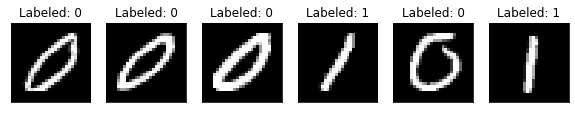

In [7]:
n_samples_show = 6

data_iter = iter(train_loader)
fig, axes = plt.subplots(nrows=1, ncols=n_samples_show, figsize=(10, 3))

while n_samples_show > 0:
    images, targets = data_iter.__next__()

    axes[n_samples_show - 1].imshow(images[0].numpy().squeeze(), cmap='gray')
    axes[n_samples_show - 1].set_xticks([])
    axes[n_samples_show - 1].set_yticks([])
    axes[n_samples_show - 1].set_title("Labeled: {}".format(targets.item()))
    
    n_samples_show -= 1

In [8]:
n_samples = 50

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [9]:
# trenowanie modelu

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_func = nn.NLLLoss()

epochs = 20
loss_list = []

model.train()
for epoch in range(epochs):
    total_loss = []
    print(i for i in enumerate(train_loader))
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))

<generator object <genexpr> at 0x000001EFAA823048>


ValueError: Expected input batch_size (25) to match target batch_size (1).

In [0]:
# nie trzeba odpalać STARE FUNKCJE
epsilon = 0.01
def update(ph, expected_ph, weight_matrix, lr):
    gradient = []
    for i, row in enumerate(weight_matrix):
        gradient_row = []
        for j, el in enumerate(row):
            weight_matrix[i][j] += epsilon
            result_plus = circuit_function(qc, weight_matrix)

            weight_matrix[i][j] -= 2*epsilon
            result_minus = circuit_function(qc, weight_matrix)

            weight_matrix[i][j] += epsilon
#             result_zero = circuit_function(qc, weight_matrix)
#             print("ph", result_zero)
#             print("exp_ph", expected_ph)
#             print("el final:", el)
#             print(result_plus - result_minus)
            result = (result_plus - result_minus)/(2*epsilon) * lr * (ph - expected_ph)
            gradient_row.append(result)
        gradient.append(gradient_row)
#     print("gradient", gradient)

    weight_matrix = weight_matrix - gradient
    return weight_matrix

In [8]:
def create_dataset(dataset_size):
    dataset = []
    for i in range(dataset_size):
        x = np.array([random.choice([0,1]), random.choice([0,1])])
        y = 1
        if np.array_equal(x, np.array([0,0])) or np.array_equal(x, np.array([1,1])):
            y = 0
        dataset.append({"x": x, "y": y})
    return dataset

dataset = create_dataset(4)
print(dataset)

[{'x': array([1, 1]), 'y': 0}, {'x': array([0, 0]), 'y': 0}, {'x': array([0, 1]), 'y': 1}, {'x': array([1, 1]), 'y': 0}]


In [51]:
# template do uczenia
import matplotlib.pyplot as plt
%matplotlib inline


#definicja rozmiaru sieci
visible = 2
hidden = 1
ancilla = visible-1

#definicja wejścia (x)oraz inicjalizacja macierzy wag
# x = np.array([random.uniform(0, 1) for n in range(visible)])

dataset = create_dataset(10)
print(dataset[0]["x"][0])
print(dataset[0]["x"][1])
print([n for n in range(visible)])


weight_matrix = np.random.rand(visible, hidden) * np.pi

#definicja parametrów uczenia
num_shots = 1000
num_epochs = 100
qr = QuantumRegister(visible + hidden + ancilla, 'q')
cr = ClassicalRegister(hidden, 'c')
qc = QuantumCircuit(qr, cr)

cost_function_data = []
lr = 0.05

for epoch in range(num_epochs):
    print("epoch: ", epoch)
    for i, element in enumerate(dataset):
#         print(element)
        x = np.array([dataset[i]["x"][n] for n in range(visible)])
        exp_ph = dataset[i]["y"]
        ph = circuit_function(qc, weight_matrix)
        weight_matrix = update(ph, exp_ph, weight_matrix, lr)
#         print("exp_ph", exp_ph, "ph", ph, "weight_matrix", weight_matrix, "cost_function", 0.5 * (ph - exp_ph)**2)   
    cost_function_data.append(0.5 * (ph - exp_ph)**2)
qc.draw()
plt.xlabel('number of epochs')
plt.ylabel('cost')
plt.plot(cost_function_data)


NameError: name 'create_dataset' is not defined

In [11]:
for i in range(len(dataset)):
    x = np.array([dataset[i]["x"][n] for n in range(visible)])
    exp_ph = dataset[i]["y"]
    ph = circuit_function(qc, weight_matrix)
    print(ph)
    print(exp_ph, "\n")

0.03
0 

0.917
1 

0.045
0 

0.912
1 

0.909
1 

0.029
0 

0.053
0 

0.041
0 

0.034
0 

0.038
0 



In [12]:
qc.draw()

In [13]:
ph = circuit_function(qc, weight_matrix)
print(ph)

0.031
